#Part from Assignment 1

In [130]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import glob
import pandas as pd
import numpy as np
np.random.seed(42)
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Data Processing

## Getting data directory

In [131]:
# Base directory of the dataset
base_dir = "/content/gdrive/MyDrive/ECGR5090/Data_Small"

# Train data
train_dir = "/content/gdrive/MyDrive/ECGR5090/Data_Small/train"

# Test data
test_dir = "/content/gdrive/MyDrive/ECGR5090/Data_Small/test"

## Mapping Images into a dataframe

In [132]:
# DME images from train folder
train_DME = train_dir+"/DME"

# DRUSEN images from train folder
train_DRUSEN = train_dir+"/DRUSEN"

data = [] 

# get a list of all image files in the folder 
image_train_DME = glob.glob(os.path.join(train_DME, '*.jpg')) + glob.glob(os.path.join(train_DME, '*.jpeg')) + glob.glob(os.path.join(train_DME, '*.png'))

# iterate through the list of image files
for file in image_train_DME:

     image = {"label": 1, "image_path" : file }
     data.append(image)

# get a list of all image files in the folder 
image_train_DRUSEN = glob.glob(os.path.join(train_DRUSEN, '*.jpg')) + glob.glob(os.path.join(train_DRUSEN, '*.jpeg')) + glob.glob(os.path.join(train_DRUSEN, '*.png'))

# iterate through the list of image files
for file in image_train_DRUSEN:

     image = {"label": 0, "image_path" : file }
     data.append(image)


# making data into a dataframe
df = pd.DataFrame(data)

# shuffle the DataFrame rows
df = df.sample(frac = 1, random_state=42)

# DME = 1, DRUSEN = 0
df

,label,image_path
2311,0,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
2059,0,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
194,1,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
1393,1,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
764,1,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
...,...,...
1638,0,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
1095,1,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
1130,1,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
1294,1,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...


## Turning images_path into Image

In [133]:
# Taking a smaller dataset
df_small = df.head(2000)

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df_small, batch_size, target_size, augmentations=None):
        self.data_df = df_small 
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentations = augmentations
        
    def __len__(self):
        return int(np.ceil(len(self.data_df) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_data = self.data_df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size].reset_index(drop=True)
        X, y = [], []
        for _, row in batch_data.iterrows():
            image = tf.keras.preprocessing.image.load_img(row["image_path"], target_size=self.target_size)
            image = tf.keras.preprocessing.image.img_to_array(image)
            if self.augmentations:
                image = self.augmentations.random_transform(image)
            X.append(image)
            y.append(row["label"])
        X = np.array(X)
        y = np.array(y)
        return X, y


train_df, test_df = train_test_split(df_small, test_size=0.2, random_state=42)
target_size = (128, 128)
batch_size = 32
augmentations = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


train_generator = CustomDataGenerator(train_df, batch_size, target_size, augmentations)
test_generator = CustomDataGenerator(test_df, batch_size, target_size)

base_model = tf.keras.applications.ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(128, 128, 3)
)

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)


history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    callbacks=early_stopping,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)


<ipython-input-133-d906b930a5e1>:72: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
50/50 [==============================] - 162s 3s/step - loss: 0.7444 - accuracy: 0.6269 - val_loss: 0.5012 - val_accuracy: 0.7400
Epoch 2/10
50/50 [==============================] - 155s 3s/step - loss: 0.4833 - accuracy: 0.7625 - val_loss: 0.4052 - val_accuracy: 0.7975
Epoch 3/10
50/50 [==============================] - 158s 3s/step - loss: 0.4365 - accuracy: 0.7900 - val_loss: 0.3786 - val_accuracy: 0.8375
Epoch 4/10
50/50 [==============================] - 156s 3s/step - loss: 0.4222 - accuracy: 0.7969 - val_loss: 0.3794 - val_accuracy: 0.8275
Epoch 5/10
50/50 [==============================] - 160s 3s/step - loss: 0.4327 - accuracy: 0.7956 - val_loss: 0.3556 - val_accuracy: 0.8325
Epoch 6/10
50/50 [==============================] - 144s 3s/step - loss: 0.4015 - accuracy: 0.8037 - val_loss: 0.3559 - val_accuracy: 0.8325


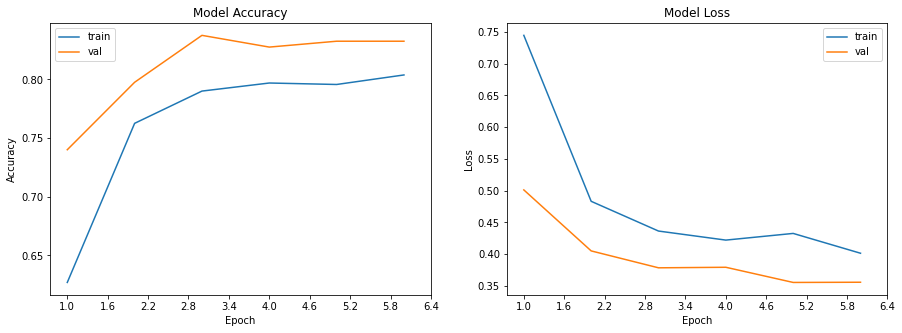

In [140]:
# #plot the training and validation accuracy and loss at each epoch

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1,len(model_history.history['accuracy'])/10))
    axs[0].legend(['train', 'val'], loc='best')

    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1,len(model_history.history['loss'])/10))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(history)



<ipython-input-141-e11c70c802e5>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator, steps=len(test_generator))


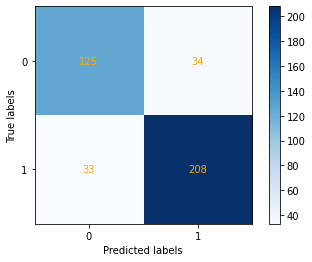

In [141]:
y_true = test_generator.data_df["label"].values
y_pred = model.predict_generator(test_generator, steps=len(test_generator))
y_pred = np.round(y_pred)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

# plot the confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([0, 1], ["0", "1"])
plt.yticks([0, 1], ["0", "1"])
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="orange")

plt.show()


# SRGAN


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import cv2
import numpy as np
np.random.seed(42)
import os
import matplotlib.pyplot as plt
import glob
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [ ]:
"""

Here, we are resizing them to 128x128 that will be  used as HR images and 
32x32 that will be used as LR images
"""

train_dir = "/content/gdrive/MyDrive/ECGR5090/Data_Small/train" 

# Test data
test_dir = "/content/gdrive/MyDrive/ECGR5090/Data_Small/test"

In [ ]:
# DME images from train folder
train_DME = train_dir+"/DME"

# DRUSEN images from train folder
train_DRUSEN = train_dir+"/DRUSEN"

data = [] 

# get a list of all image files in the folder 
image_train_DME = glob.glob(os.path.join(train_DME, '*.jpg')) + glob.glob(os.path.join(train_DME, '*.jpeg')) + glob.glob(os.path.join(train_DME, '*.png'))

# iterate through the list of image files
for file in image_train_DME:

     image = {"label": 1, "image_path" : file }
     data.append(image)

# get a list of all image files in the folder 
image_train_DRUSEN = glob.glob(os.path.join(train_DRUSEN, '*.jpg')) + glob.glob(os.path.join(train_DRUSEN, '*.jpeg')) + glob.glob(os.path.join(train_DRUSEN, '*.png'))

# iterate through the list of image files
for file in image_train_DRUSEN:

     image = {"label": 0, "image_path" : file }
     data.append(image)


# making data into a dataframe
df = pd.DataFrame(data)

# shuffle the DataFrame rows
df = df.sample(frac = 1, random_state=42)

# DME = 1, DRUSEN = 0
df

,label,image_path
2311,0,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
2059,0,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
194,1,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
1393,1,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
764,1,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
...,...,...
1638,0,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
1095,1,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
1130,1,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...
1294,1,/content/gdrive/MyDrive/ECGR5090/Data_Small/tr...


In [ ]:
for class_name in ["DME", "DRUSEN"]:
    hr_dir = train_dir + "/hr_images_" + class_name
    lr_dir = train_dir + "/lr_images_" + class_name
    os.makedirs(hr_dir, exist_ok=True)
    os.makedirs(lr_dir, exist_ok=True)
    for img in os.listdir(train_dir + "/" + class_name):
        img_array = cv2.imread(train_dir + "/" + class_name + "/" + img)
        
        img_array = cv2.resize(img_array, (128,128))
        lr_img_array = cv2.resize(img_array,(32,32))
        cv2.imwrite(hr_dir + "/" + img, img_array)
        cv2.imwrite(lr_dir + "/" + img, lr_img_array)

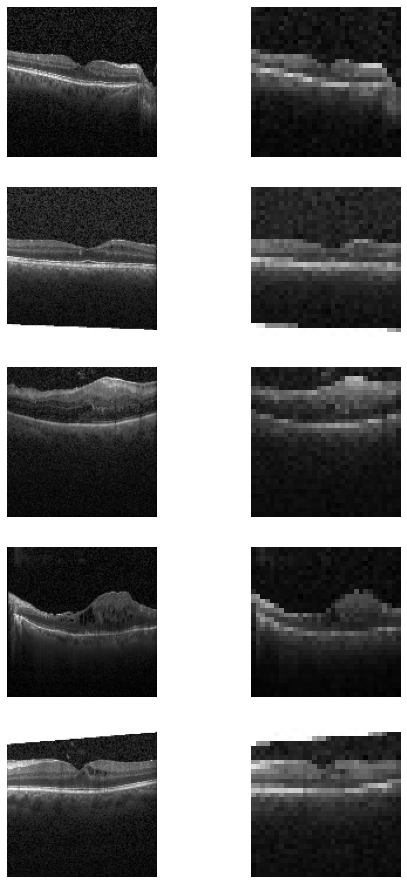

hr_img.shape: (128, 128, 3)
lr_img.shape: (32, 32, 3)


In [ ]:
import matplotlib.pyplot as plt
import os

class_name = "DME"  # choose which class to visualize
hr_dir = train_dir + "/hr_images_" + class_name
lr_dir = train_dir + "/lr_images_" + class_name

# get a list of image file names
img_files = os.listdir(hr_dir)

# choose how many images to visualize
num_images = 5

# plot the images
fig, ax = plt.subplots(num_images, 2, figsize=(8, 16))
for i in range(num_images):
    # read the high-resolution image
    hr_img = plt.imread(os.path.join(hr_dir, img_files[i]))
    # read the low-resolution image
    lr_img = plt.imread(os.path.join(lr_dir, img_files[i]))
    # plot the images side by side
    ax[i, 0].imshow(hr_img)
    ax[i, 1].imshow(lr_img)
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()
print('hr_img.shape:', hr_img.shape)
print('lr_img.shape:', lr_img.shape)

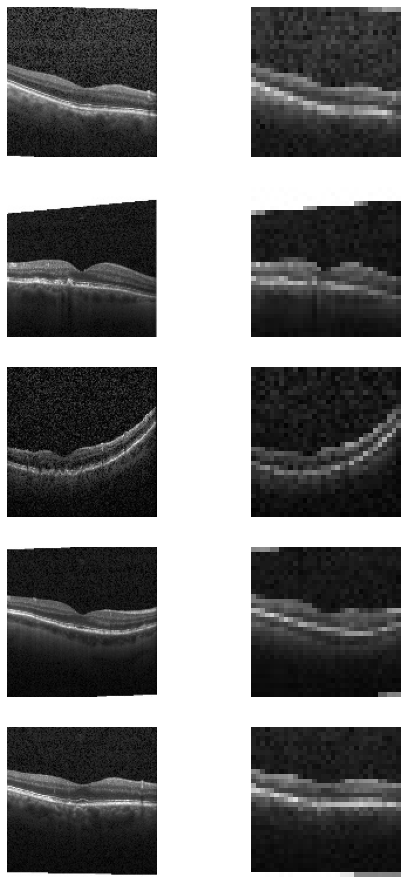

hr_img.shape: (128, 128, 3)
lr_img.shape: (32, 32, 3)


In [ ]:
class_name = "DRUSEN"  # choose which class to visualize
hr_dir = train_dir + "/hr_images_" + class_name
lr_dir = train_dir + "/lr_images_" + class_name

# get a list of image file names
img_files = os.listdir(hr_dir)

# choose how many images to visualize
num_images = 5

# plot the images
fig, ax = plt.subplots(num_images, 2, figsize=(8, 16))
for i in range(num_images):
    # read the high-resolution image
    hr_img = plt.imread(os.path.join(hr_dir, img_files[i]))
    # read the low-resolution image
    lr_img = plt.imread(os.path.join(lr_dir, img_files[i]))
    # plot the images side by side
    ax[i, 0].imshow(hr_img)
    ax[i, 1].imshow(lr_img)
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()
print('hr_img.shape:', hr_img.shape)
print('lr_img.shape:', lr_img.shape)

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [ ]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [ ]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [ ]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [ ]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [ ]:
#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [ ]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


In [ ]:
n = 1000

lr_images = []
hr_images = []

for class_name in ["DME", "DRUSEN"]:
    lr_list = os.listdir("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/lr_images_" + class_name)[:n]
    for img in lr_list:
        img_lr = cv2.imread("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/lr_images_" + class_name + "/" + img)
        img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
        lr_images.append(img_lr)   
    
    hr_list = os.listdir("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/hr_images_" + class_name)[:n]
    for img in hr_list:
        img_hr = cv2.imread("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/hr_images_" + class_name + "/" + img)
        img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
        hr_images.append(img_hr) 

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


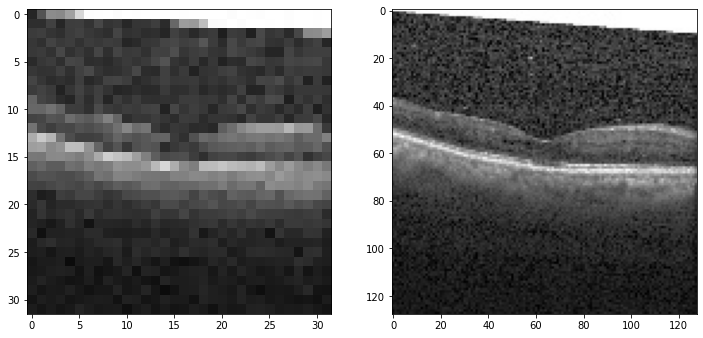

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [ ]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.


In [ ]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.30, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_45 (Conv2D)             (None, 32, 32, 64)   15616       ['input_4[0][0]']                
                                                                                                  
 p_re_lu_19 (PReLU)             (None, 32, 32, 64)   64          ['conv2d_45[0][0]']              
                                                                                                  
 conv2d_46 (Conv2D)             (None, 32, 32, 64)   36928       ['p_re_lu_19[0][0]']             
                                                                                            

In [ ]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model_4 (Functional)           (None, 128, 128, 3)  2044291     ['input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_5 (Functional)           (None, 1)            38249281    ['model_4[0][0]']          

In [ ]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
epochs = 200
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []

In [ ]:
   #Enumerate training over batches. 
for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

100%|██████████| 1400/1400 [00:00<00:00, 578695.73it/s]


In [ ]:
fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

In [ ]:
#First, train the discriminator on fake and real HR images. 
discriminator.trainable = True
d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

In [ ]:
#Now, train the generator by fixing discriminator as non-trainable
discriminator.trainable = False

In [ ]:
 #Average the discriminator loss, just for reporting purposes. 
d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 

In [ ]:
#Extract VGG features, to be used towards calculating loss
image_features = vgg.predict(hr_imgs)

1/1 [==============================] - 0s 174ms/step


In [ ]:
#Train the generator via GAN. 
#Remember that we have 2 losses, adversarial loss and content (VGG) loss
g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

In [ ]:
#Save losses to a list so we can average and report. 
d_losses.append(d_loss)
g_losses.append(g_loss)

In [ ]:
#Convert the list of losses to an array to make it easy to average    
g_losses = np.array(g_losses)
d_losses = np.array(d_losses)

In [ ]:
    #Report the progress during training. 
print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

epoch: 200 g_loss: 1440.334228515625 d_loss: [3.02111584e-05 1.00000000e+00]


In [ ]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

In [ ]:
generator = load_model('gen_e_200.h5', compile=False)


In [ ]:
import os
import cv2
import numpy as np

def load_data(directory):
  images = []
  labels = []
  classes = sorted(os.listdir(directory))
  for i, class_name in enumerate(classes):
    class_dir = os.path.join(directory, class_name)
    for image_file in os.listdir(class_dir):
      image_path = os.path.join(class_dir, image_file)
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      images.append(image)
      labels.append(i)
      return np.array(images), np.array(labels)


In [ ]:
test_images, test_labels = load_data('/content/gdrive/MyDrive/ECGR5090/Data_Small/test')


In [ ]:
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

In [ ]:
# generate image from source
gen_image = generator.predict(src_image)

1/1 [==============================] - 0s 486ms/step


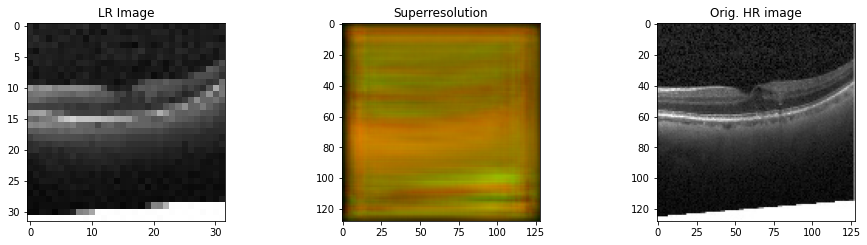

In [ ]:
# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])
plt.show()

In [ ]:
lr_images_DME = cv2.imread("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/lr_images_DME/DME-1072015-4.jpeg")
hr_images_DME = cv2.imread("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/hr_images_DME/DME-1072015-4.jpeg")
lr_images_DRUSEN = cv2.imread("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/lr_images_DRUSEN/DRUSEN-1001666-4.jpeg")
hr_images_DRUSEN = cv2.imread("/content/gdrive/MyDrive/ECGR5090/Data_Small/train/hr_images_DRUSEN/DRUSEN-1001666-4.jpeg")

In [ ]:
#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
lr_images_DME = cv2.cvtColor(lr_images_DME, cv2.COLOR_BGR2RGB)
hr_images_DME = cv2.cvtColor(hr_images_DME, cv2.COLOR_BGR2RGB)
lr_images_DRUSEN = cv2.cvtColor(lr_images_DRUSEN, cv2.COLOR_BGR2RGB)
hr_images_DRUSEN = cv2.cvtColor(hr_images_DRUSEN, cv2.COLOR_BGR2RGB)

In [ ]:
lr_images_DME = lr_images_DME / 255.
hr_images_DME = hr_images_DME / 255.
lr_images_DRUSEN = lr_images_DRUSEN / 255.
hr_images_DRUSEN = hr_images_DRUSEN / 255.

In [ ]:
lr_images_DME = np.expand_dims(lr_images_DME, axis=0)
hr_images_DME = np.expand_dims(hr_images_DME, axis=0)
lr_images_DRUSEN = np.expand_dims(lr_images_DRUSEN, axis=0)
hr_images_DRUSEN = np.expand_dims(hr_images_DRUSEN, axis=0)

In [ ]:
generated_lr_images_DME = generator.predict(lr_images_DME)
generated_hr_images_DME = generator.predict(hr_images_DME)

1/1 [==============================] - 1s 953ms/step


1/1 [==============================] - 2s 2s/step


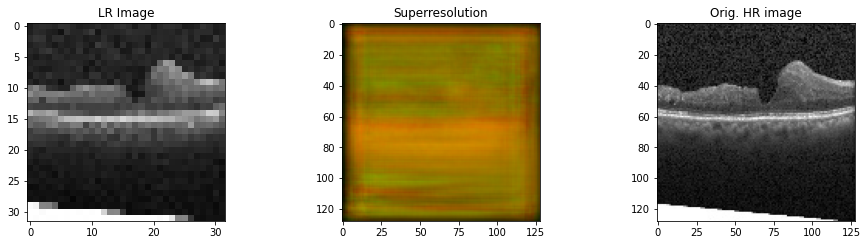

In [ ]:
# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(lr_images_DME[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_lr_images_DME[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(hr_images_DME[0,:,:,:])

plt.show()

# Performance comparison

In terms of performance, binary image classifiers using CNN transfer learning are often able to achieve high accuracy rates when fine-tuned on a specific dataset. This is because the pre-trained model has already learned to recognize common features in images, which can be useful for the specific classification task. On the other hand, SRGAN with binary class is designed to generate high-quality, high-resolution images from low-resolution inputs, which can be useful for tasks such as image super-resolution.

For the task of binary image classification and the evaluation metric is accuracy, then a binary image classifier would be the appropriate model to use. Similarly, for the task of image super-resolution and the evaluation metric is the mean-squared error (MSE) or peak signal-to-noise ratio (PSNR), then an SRGAN with binary class would be the appropriate model to use.

Both models have their own strengths and weaknesses and perform differently depending on the task and evaluation metric. However, SRGAN has shown a better performance in terms of generating images lower resolution to higher resolution. 